In [77]:
import queue
import numpy as np
from typing import List, Tuple
import heapq
import math
import datetime
import pandas as pd
from classes.random_gen import RandomNumberGenerator
from classes.task import Task
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from tabulate import tabulate


In [87]:
sa_cooling = pd.read_csv('./../res/sa_cooling.csv')
sa_initial = pd.read_csv('./../res/sa_initial.csv')
sa_neighbor = pd.read_csv('./../res/sa_neighbor.csv')
sa_best = pd.read_csv('./../res/sa_best_params.csv')

rs_initial = pd.read_csv('./../res/rs_initial.csv')
rs_neighbor = pd.read_csv('./../res/rs_neighbor.csv')
rs_best = pd.read_csv('./../res/rs_best_params.csv')


# SA -> COOLING

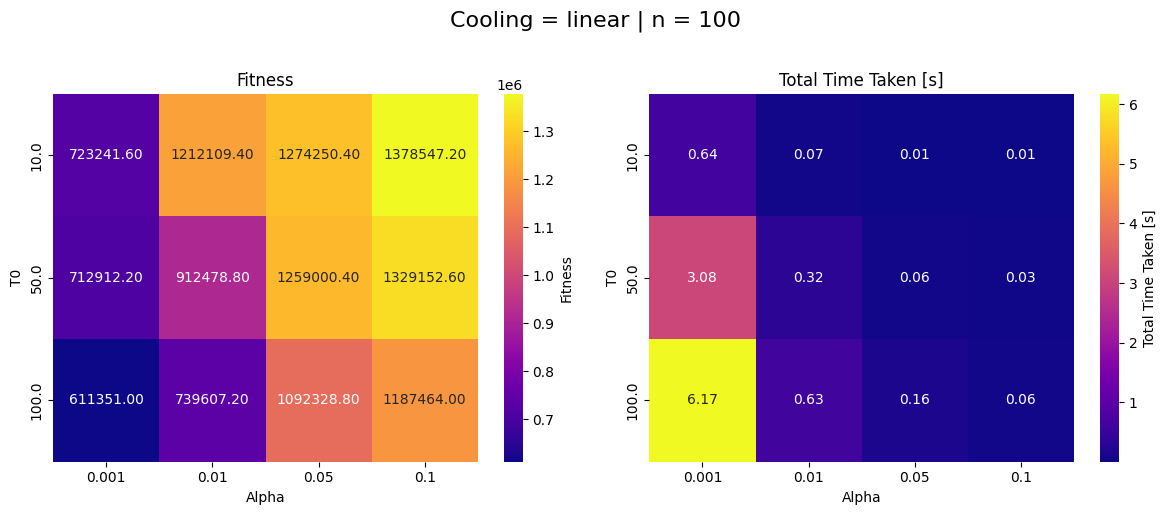

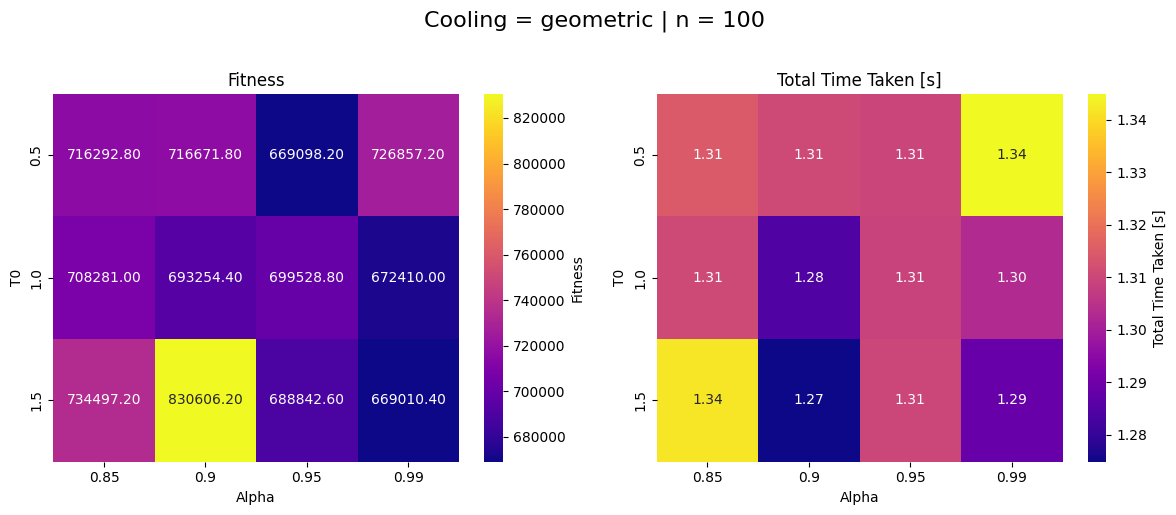

In [79]:
def show_best_params(n, cooling, greek):
    grouped = sa_cooling[(sa_cooling['n'] == n) & (sa_cooling['cooling'] == cooling)].groupby(['T0', greek]).agg(
    fitness=('best_fit', 'mean'),
    time_till_best=('time_till_best', 'mean'),
    time_taken=('time_taken', 'mean'),
    ).reset_index()

    metrics = ['fitness', 'time_taken']
    titles = ['Fitness', 'Total Time Taken [s]']

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    fig.suptitle(
        f"Cooling = {cooling} | n = {n}", 
        fontsize=16, 
        y=1.02  # Adjust vertical position (default=1.0)
    )


    for i, (metric, title) in enumerate(zip(metrics, titles)):
        heatmap_data = grouped.pivot(index='T0', columns=greek, values=metric)
        
        # Plot heatmap
        sns.heatmap(
            heatmap_data,
            ax=axes[i],
            cmap='plasma',
            annot=True,
            fmt=".2f",
            cbar_kws={'label': title}
        )
        
        axes[i].set_title(title)
        axes[i].set_xlabel('Alpha')
        axes[i].set_ylabel('T0')

    plt.tight_layout()
    plt.show()
    
show_best_params(100, 'linear', 'beta')
show_best_params(100, 'geometric', 'alpha')

# SA -> INITIAL 

+-----+---------+--------------+----------+-------------+------------+----------------+
|  n  | initial | initial_size | fitness  | fitness_std | time_taken | time_taken_std |
+-----+---------+--------------+----------+-------------+------------+----------------+
| 20  |  group  |     10.0     | 22203.0  |  5870.319   |   0.228    |     0.016      |
| 20  |  group  |    100.0     | 24586.0  |  5397.631   |   0.227    |     0.007      |
| 20  |  group  |    1000.0    | 27634.8  |  12770.565  |   0.272    |     0.012      |
| 20  |  group  |   10000.0    | 20345.6  |  8208.324   |   0.684    |     0.029      |
| 20  | single  |     N/A      | 20869.2  |  2645.283   |   0.229    |     0.016      |
| 40  |  group  |     10.0     | 114709.0 |  24568.914  |   0.364    |     0.014      |
| 40  |  group  |    100.0     | 126644.8 |  23336.342  |   0.367    |     0.013      |
| 40  |  group  |    1000.0    | 105646.6 |  15176.464  |   0.417    |     0.019      |
| 40  |  group  |   10000.0    |

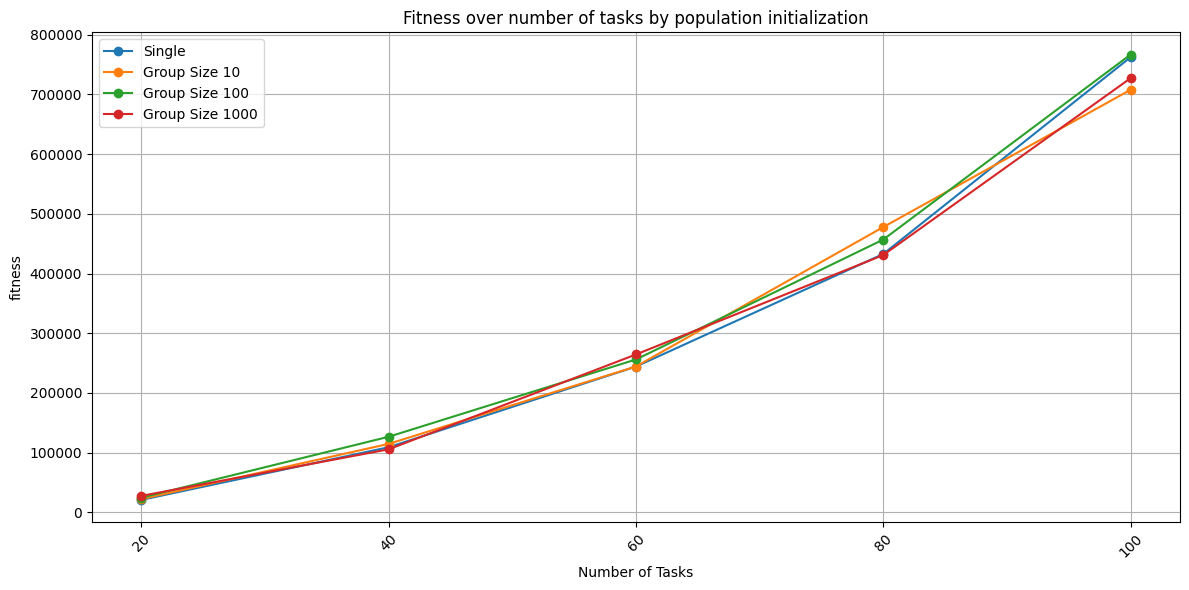

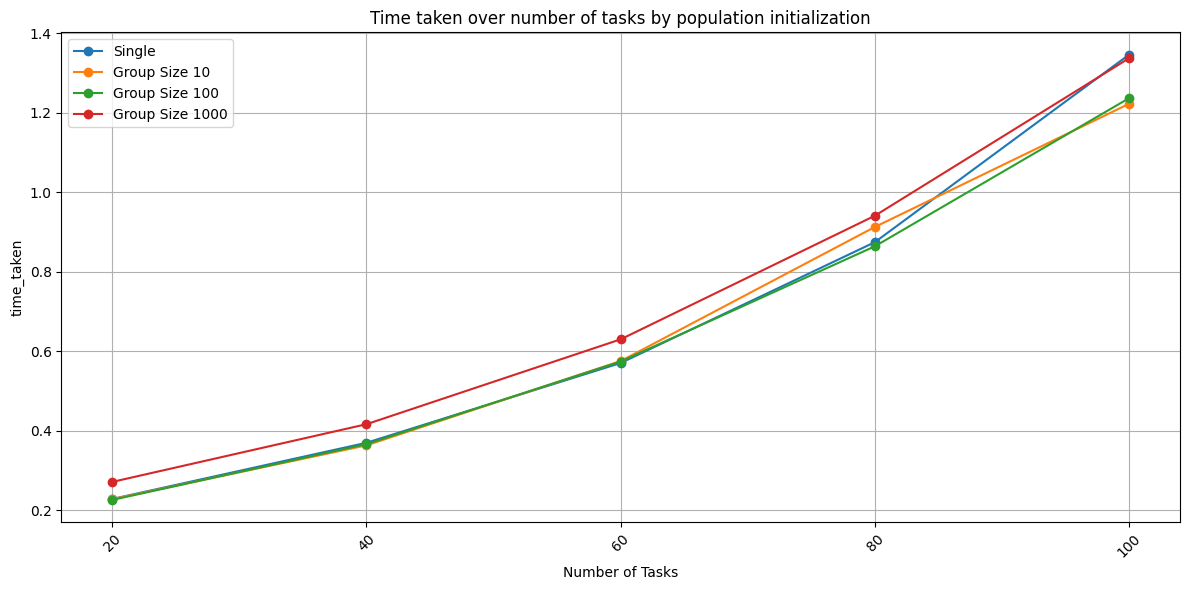

In [ ]:
sa_initial['initial_size'] = sa_initial['initial_size'].fillna('N/A')
df_grouped = sa_initial.groupby(['n', 'initial', 'initial_size']).agg(
    fitness=('best_fit', 'mean'),
    fitness_std=('best_fit', 'std'),
    time_taken=('time_taken', 'mean'),
    time_taken_std=('time_taken', 'std'),
).reset_index()

tmp = df_grouped.copy().round(3)
tmp = tmp.sort_values(by=['n', 'initial', 'initial_size'])
print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))

def create_plot(title, metric):
    X = df_grouped['n'].unique()
    Y1 = df_grouped[df_grouped['initial'] == 'single']
    Y2 = df_grouped[(df_grouped['initial'] == 'group') & (df_grouped['initial_size'] == 10)]
    Y3 = df_grouped[(df_grouped['initial'] == 'group') & (df_grouped['initial_size'] == 100)]
    Y4 = df_grouped[(df_grouped['initial'] == 'group') & (df_grouped['initial_size'] == 1000)]

    Y1_std = df_grouped[df_grouped['initial'] == 'single']['fitness_std']
    Y2_std = df_grouped[(df_grouped['initial'] == 'group') & (df_grouped['initial_size'] == 10)]['fitness_std']
    Y3_std = df_grouped[(df_grouped['initial'] == 'group') & (df_grouped['initial_size'] == 100)]['fitness_std']
    Y4_std = df_grouped[(df_grouped['initial'] == 'group') & (df_grouped['initial_size'] == 1000)]['fitness_std']

    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Number of Tasks')
    plt.ylabel(metric)
    plt.xticks(X, rotation=45)
    plt.grid()
    plt.plot(X, Y1[metric], label='Single', marker='o')
    plt.plot(X, Y2[metric], label='Group Size 10', marker='o')
    plt.plot(X, Y3[metric], label='Group Size 100', marker='o')
    plt.plot(X, Y4[metric], label='Group Size 1000', marker='o')
    # plt.fill_between(X, Y1['fitness'] - Y1_std, Y1['fitness'] + Y1_std, alpha=0.2)
    # plt.fill_between(X, Y2['fitness'] - Y2_std, Y2['fitness'] + Y2_std, alpha=0.2)
    # plt.fill_between(X, Y3['fitness'] - Y3_std, Y3['fitness'] + Y3_std, alpha=0.2)
    # plt.fill_between(X, Y4['fitness'] - Y4_std, Y4['fitness'] + Y4_std, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
create_plot('Fitness over number of tasks by population initialization', 'fitness')
create_plot('Time [s] taken over number of tasks by population initialization', 'time_taken')

# SA -> NEIGHBOR

+-----+----------+----------+-------------+------------+----------------+
|  n  | neighbor | fitness  | fitness_std | time_taken | time_taken_std |
+-----+----------+----------+-------------+------------+----------------+
| 20  |  close   | 28639.6  |  6284.565   |   0.279    |     0.063      |
| 20  |   wide   | 19866.4  |  5791.586   |    0.5     |     0.019      |
| 40  |  close   | 92634.0  |  23967.609  |   0.375    |     0.018      |
| 40  |   wide   | 110996.4 |  3687.497   |   0.812    |     0.033      |
| 60  |  close   | 246499.4 |  34269.891  |   0.573    |     0.032      |
| 60  |   wide   | 245047.2 |  25924.445  |   1.523    |     0.121      |
| 80  |  close   | 481289.6 |  75054.91   |    0.89    |     0.027      |
| 80  |   wide   | 428767.8 |  40041.62   |   2.136    |     0.201      |
| 100 |  close   | 726485.4 | 134296.355  |   1.259    |     0.078      |
| 100 |   wide   | 681658.2 |  52183.129  |   3.808    |     0.584      |
+-----+----------+----------+---------

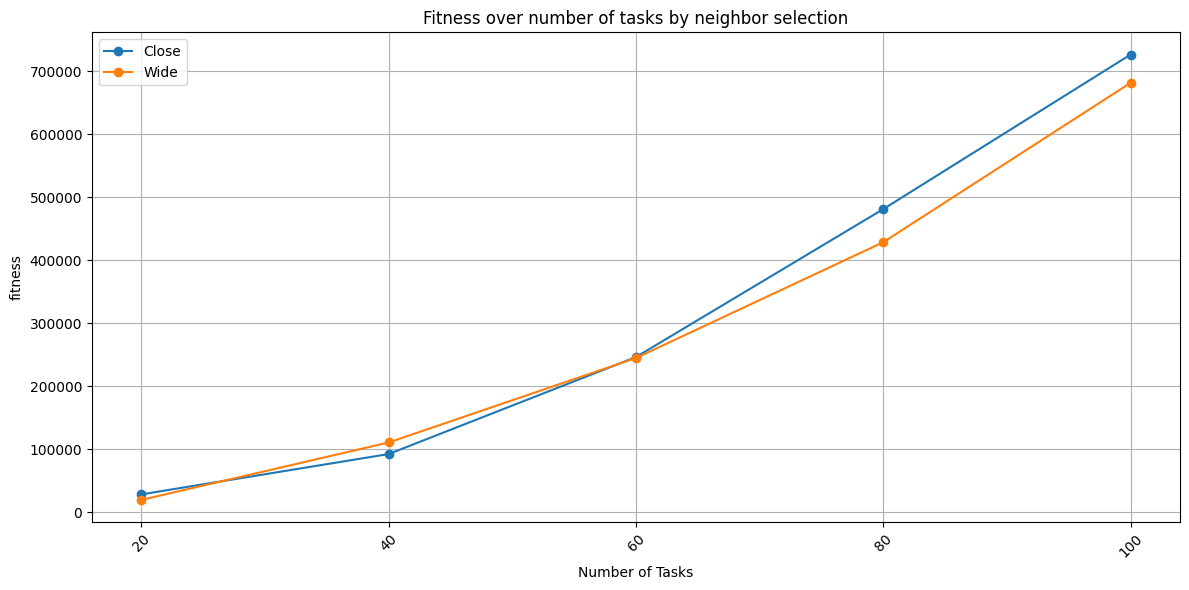

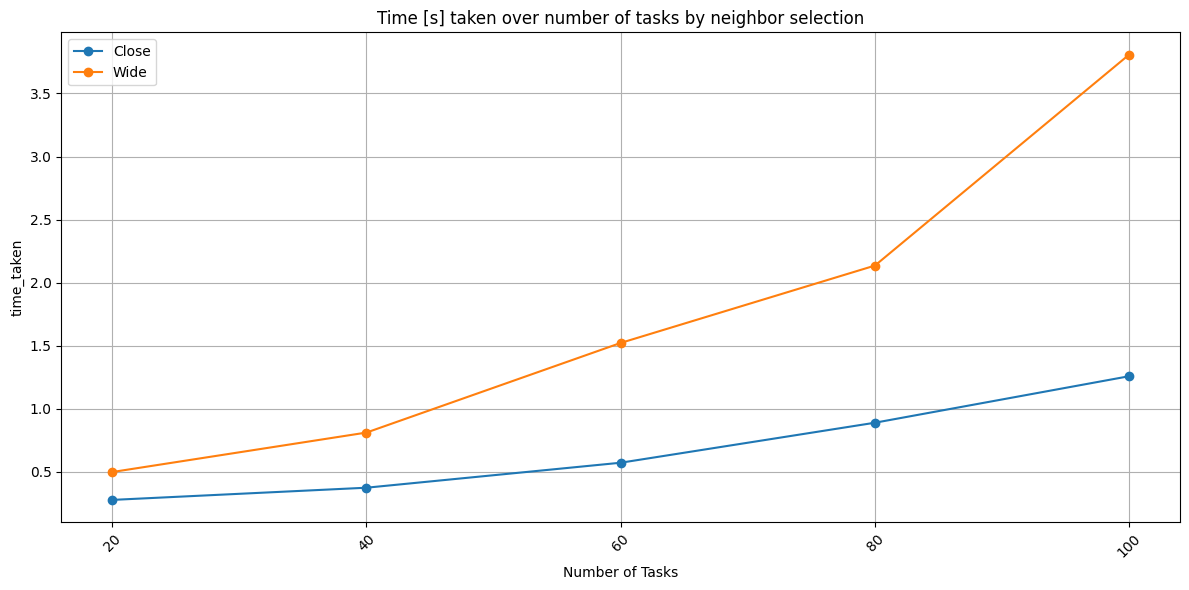

In [83]:
df_grouped = sa_neighbor.groupby(['n', 'neighbor']).agg(
    fitness=('best_fit', 'mean'),
    fitness_std=('best_fit', 'std'),
    time_taken=('time_taken', 'mean'),
    time_taken_std=('time_taken', 'std'),
).reset_index()

tmp = df_grouped.copy().round(3)
tmp = tmp.sort_values(by=['n', 'neighbor'])
print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))

def create_plot(title, metric):
    X = df_grouped['n'].unique()
    Y1 = df_grouped[df_grouped['neighbor'] == 'close']
    Y2 = df_grouped[df_grouped['neighbor'] == 'wide']

    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Number of Tasks')
    plt.ylabel(metric)
    plt.xticks(X, rotation=45)
    plt.grid()
    plt.plot(X, Y1[metric], label='Close', marker='o')
    plt.plot(X, Y2[metric], label='Wide', marker='o')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
create_plot('Fitness over number of tasks by neighbor selection', 'fitness')
create_plot('Time [s] taken over number of tasks by neighbor selection', 'time_taken')

# RS -> INITIAL

+-----+---------+--------------+----------+-------------+------------+----------------+
|  n  | initial | initial_size | fitness  | fitness_std | time_taken | time_taken_std |
+-----+---------+--------------+----------+-------------+------------+----------------+
| 20  |  group  |     10.0     | 23821.4  |  6638.102   |    0.01    |     0.008      |
| 20  |  group  |    100.0     | 22199.8  |  6659.179   |   0.009    |     0.002      |
| 20  |  group  |    1000.0    | 16143.6  |  4250.344   |   0.027    |     0.007      |
| 20  |  group  |   10000.0    | 23912.2  |  7296.759   |   0.182    |      0.05      |
| 20  | single  |     N/A      | 22774.2  |  5985.593   |   0.012    |     0.008      |
| 40  |  group  |     10.0     | 101738.2 |  14268.325  |   0.022    |     0.008      |
| 40  |  group  |    100.0     | 130538.8 |  27399.799  |   0.028    |     0.006      |
| 40  |  group  |    1000.0    | 101759.4 |  25496.024  |   0.043    |     0.006      |
| 40  |  group  |   10000.0    |

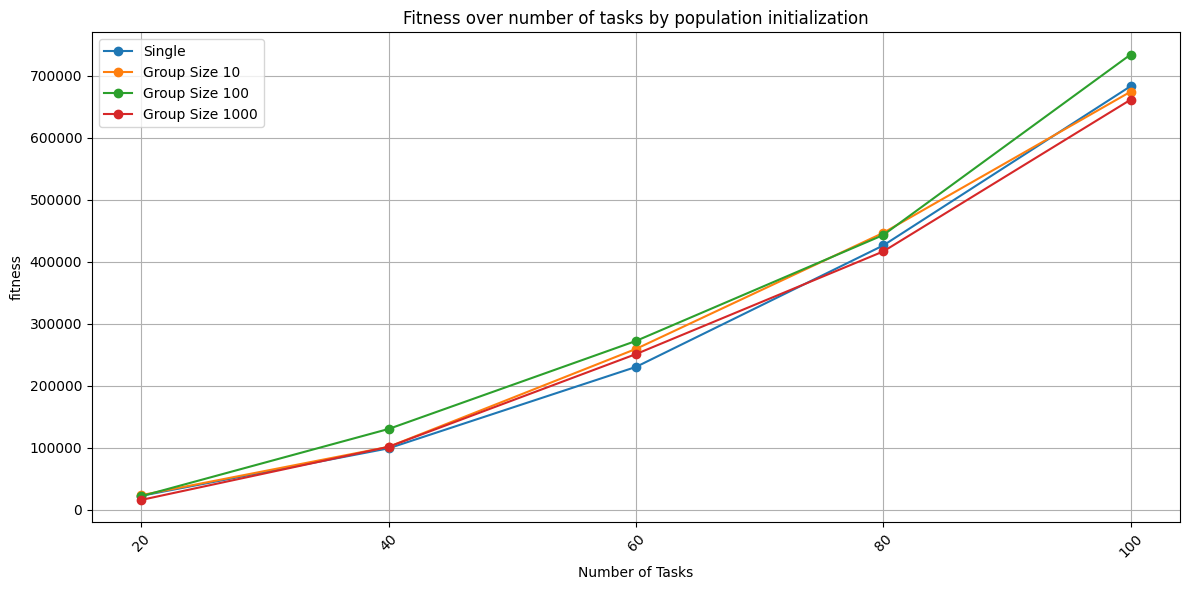

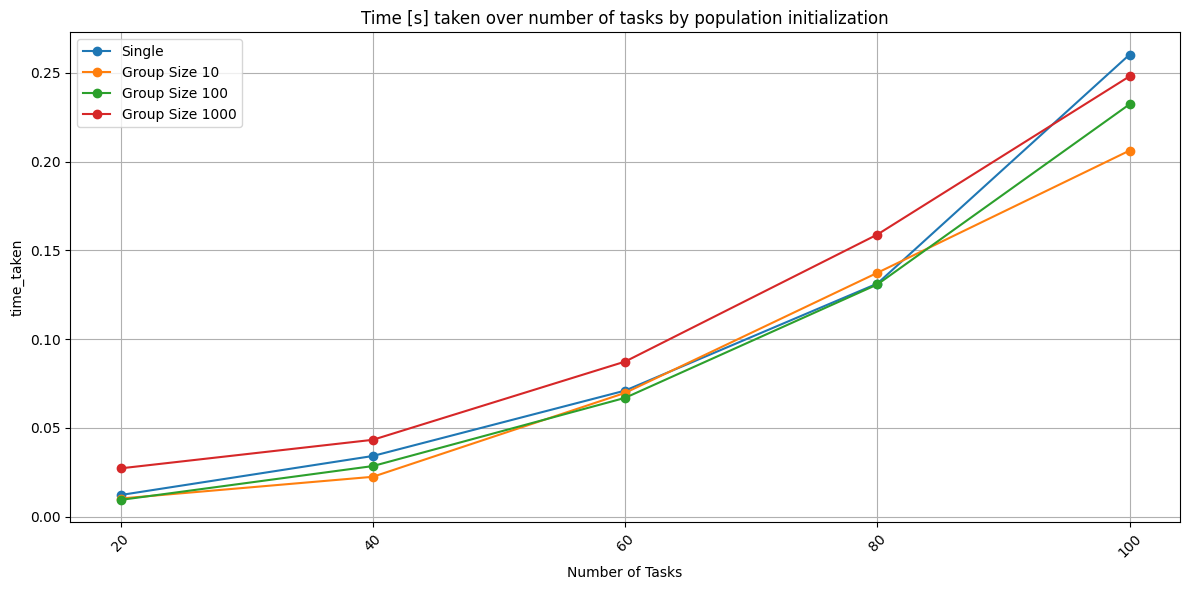

In [85]:
rs_initial['initial_size'] = rs_initial['initial_size'].fillna('N/A')
df_grouped = rs_initial.groupby(['n', 'initial', 'initial_size']).agg(
    fitness=('best_fit', 'mean'),
    fitness_std=('best_fit', 'std'),
    time_taken=('time_taken', 'mean'),
    time_taken_std=('time_taken', 'std'),
).reset_index()

tmp = df_grouped.copy().round(3)
tmp = tmp.sort_values(by=['n', 'initial', 'initial_size'])
print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))

def create_plot(title, metric):
    X = df_grouped['n'].unique()
    Y1 = df_grouped[df_grouped['initial'] == 'single']
    Y2 = df_grouped[(df_grouped['initial'] == 'group') & (df_grouped['initial_size'] == 10)]
    Y3 = df_grouped[(df_grouped['initial'] == 'group') & (df_grouped['initial_size'] == 100)]
    Y4 = df_grouped[(df_grouped['initial'] == 'group') & (df_grouped['initial_size'] == 1000)]

    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Number of Tasks')
    plt.ylabel(metric)
    plt.xticks(X, rotation=45)
    plt.grid()
    plt.plot(X, Y1[metric], label='Single', marker='o')
    plt.plot(X, Y2[metric], label='Group Size 10', marker='o')
    plt.plot(X, Y3[metric], label='Group Size 100', marker='o')
    plt.plot(X, Y4[metric], label='Group Size 1000', marker='o')
    # plt.fill_between(X, Y1['fitness'] - Y1_std, Y1['fitness'] + Y1_std, alpha=0.2)
    # plt.fill_between(X, Y2['fitness'] - Y2_std, Y2['fitness'] + Y2_std, alpha=0.2)
    # plt.fill_between(X, Y3['fitness'] - Y3_std, Y3['fitness'] + Y3_std, alpha=0.2)
    # plt.fill_between(X, Y4['fitness'] - Y4_std, Y4['fitness'] + Y4_std, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
create_plot('Fitness over number of tasks by population initialization', 'fitness')
create_plot('Time [s] taken over number of tasks by population initialization', 'time_taken')

# RS -> NEIGHBOR

+-----+----------+----------+-------------+------------+----------------+
|  n  | neighbor | fitness  | fitness_std | time_taken | time_taken_std |
+-----+----------+----------+-------------+------------+----------------+
| 20  |  close   | 18283.2  |  6947.892   |   0.012    |     0.007      |
| 20  |   wide   | 21922.2  |  7828.599   |    0.03    |      0.01      |
| 40  |  close   | 113970.0 |  14474.659  |    0.03    |     0.005      |
| 40  |   wide   | 106448.8 |  18275.22   |   0.093    |     0.037      |
| 60  |  close   | 259386.2 |  31327.53   |   0.081    |     0.019      |
| 60  |   wide   | 222150.8 |  36333.134  |   0.168    |      0.01      |
| 80  |  close   | 469185.0 |  35110.357  |   0.128    |     0.028      |
| 80  |   wide   | 510366.2 |  61434.544  |   0.292    |     0.043      |
| 100 |  close   | 662717.2 |  83197.35   |   0.237    |     0.024      |
| 100 |   wide   | 694311.6 |  34369.912  |   0.492    |     0.072      |
+-----+----------+----------+---------

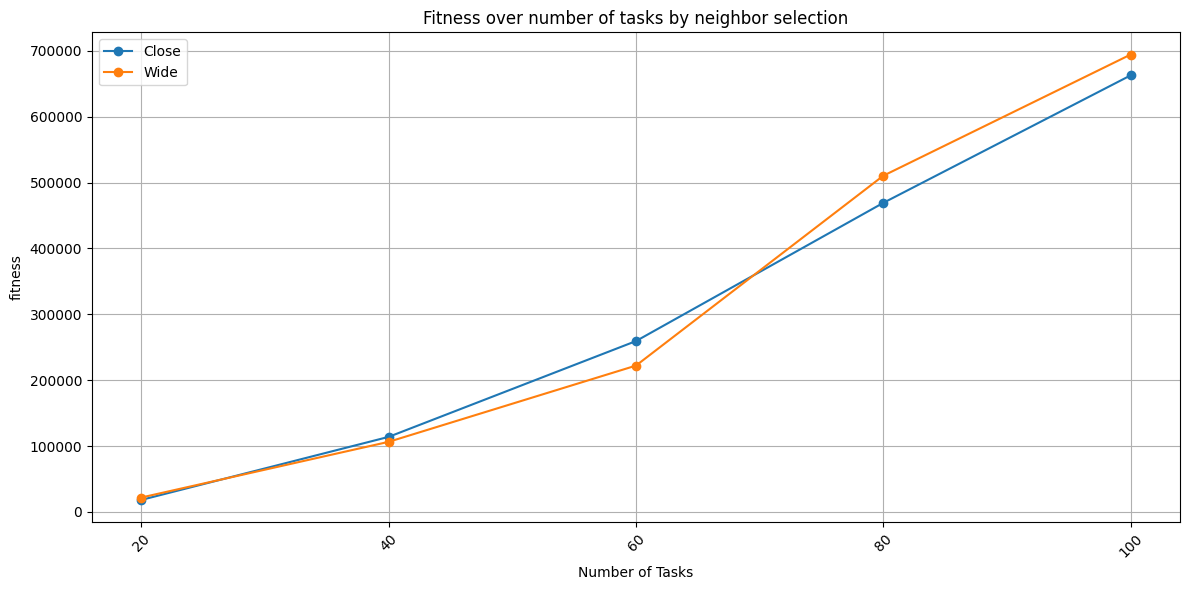

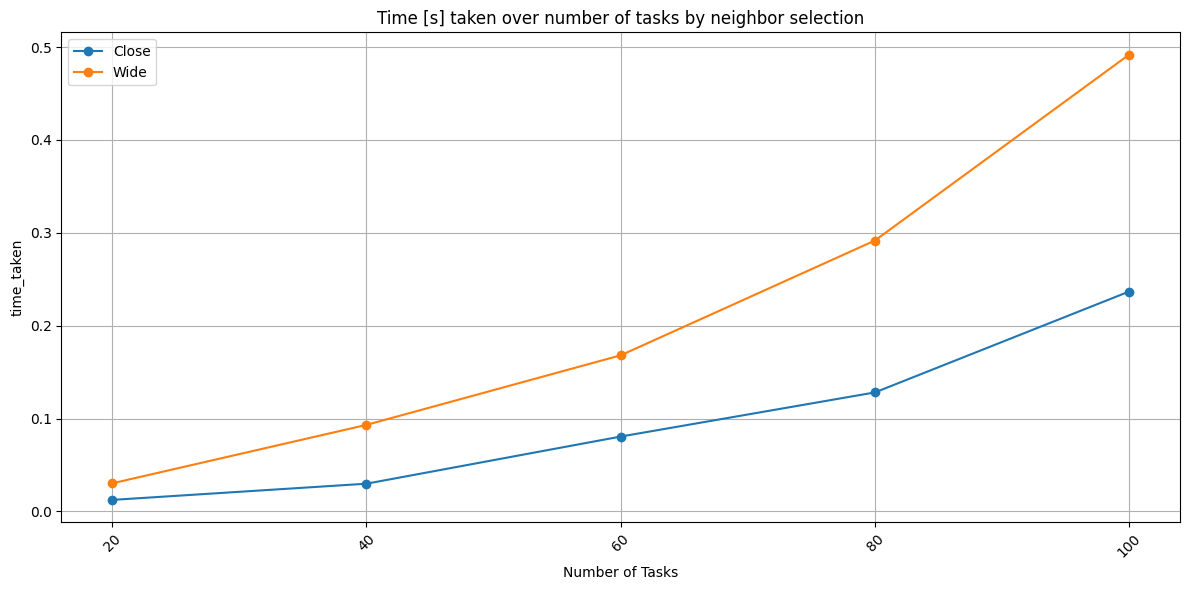

In [86]:
df_grouped = rs_neighbor.groupby(['n', 'neighbor']).agg(
    fitness=('best_fit', 'mean'),
    fitness_std=('best_fit', 'std'),
    time_taken=('time_taken', 'mean'),
    time_taken_std=('time_taken', 'std'),
).reset_index()

tmp = df_grouped.copy().round(3)
tmp = tmp.sort_values(by=['n', 'neighbor'])
print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))

def create_plot(title, metric):
    X = df_grouped['n'].unique()
    Y1 = df_grouped[df_grouped['neighbor'] == 'close']
    Y2 = df_grouped[df_grouped['neighbor'] == 'wide']

    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Number of Tasks')
    plt.ylabel(metric)
    plt.xticks(X, rotation=45)
    plt.grid()
    plt.plot(X, Y1[metric], label='Close', marker='o')
    plt.plot(X, Y2[metric], label='Wide', marker='o')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
create_plot('Fitness over number of tasks by neighbor selection', 'fitness')
create_plot('Time [s] taken over number of tasks by neighbor selection', 'time_taken')

# COMPARE SA vs RS

     n   fitness  initial_fit  time_taken
0   20   21220.8      35518.4    0.499803
1   40  112681.8     185676.5    0.897994
2   60  242748.3     419763.9    1.424964
3   80  458075.5     799453.3    2.477187
4  100  725842.1    1263505.6    3.961199
     n   fitness  initial_fit  time_taken
0   20   20334.8      37154.9    0.080269
1   40  106971.5     186799.8    0.269587
2   60  258652.5     443770.5    0.519444
3   80  433657.9     739454.5    0.918072
4  100  693987.0    1208252.2    1.580362


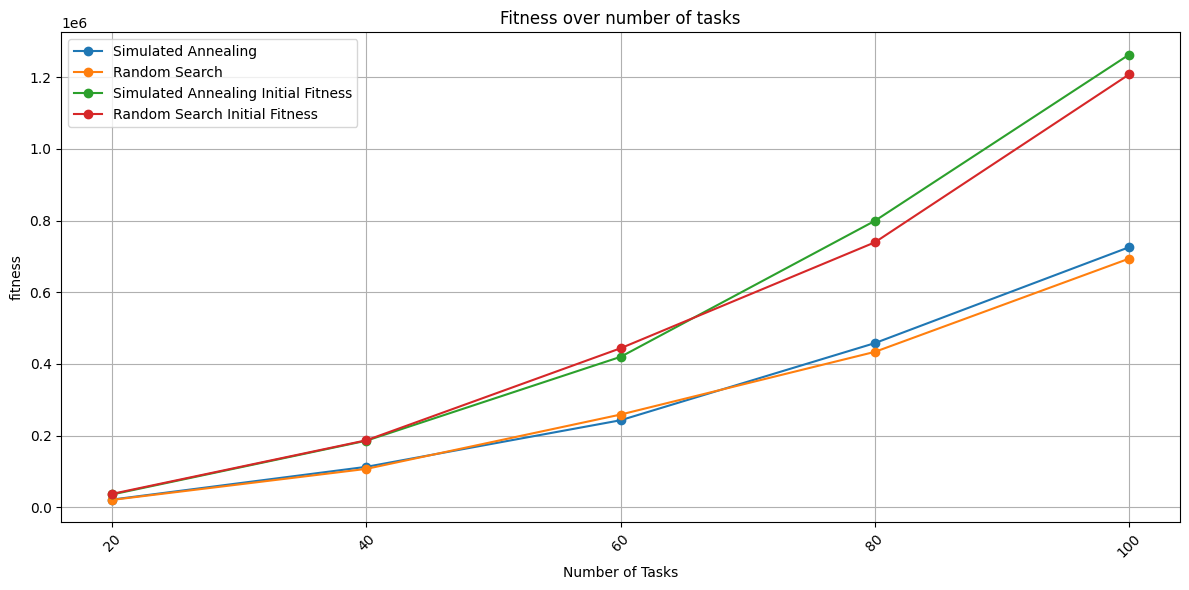

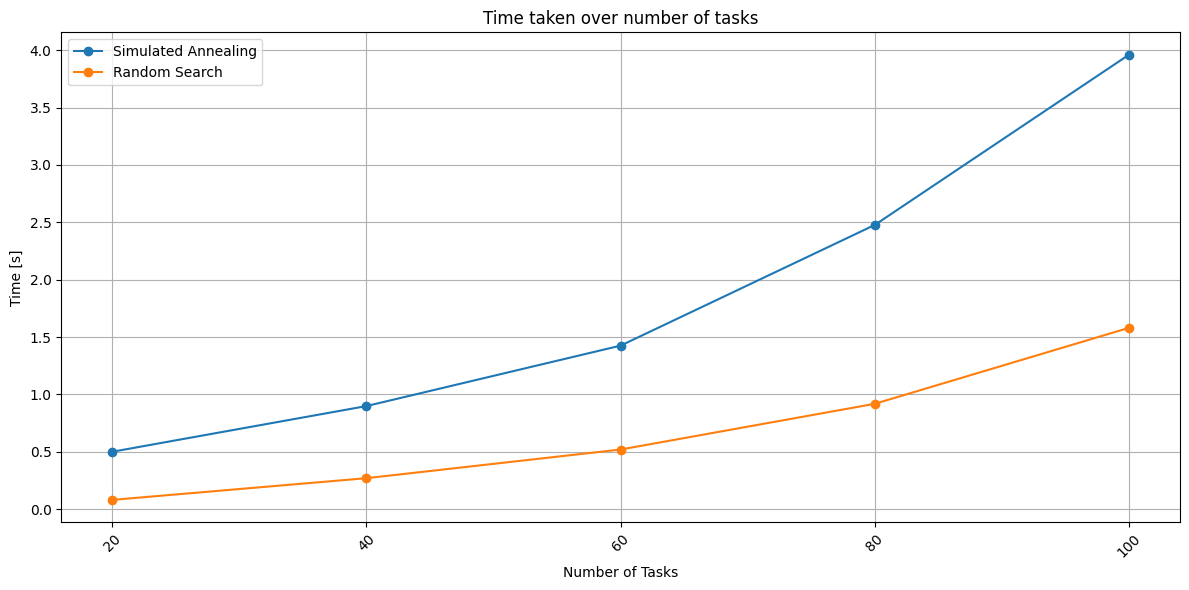

In [92]:
sa_grouped = sa_best.groupby(['n']).agg(
    fitness=('best_fit', 'mean'),
    initial_fit = ('initial_fitness', 'mean'),
    time_taken=('time_taken', 'mean'),
).reset_index()

rs_grouped = rs_best.groupby(['n']).agg(
    fitness=('best_fit', 'mean'),
    initial_fit = ('initial_fitness', 'mean'),
    time_taken=('time_taken', 'mean'),
).reset_index()

#print
print(sa_grouped)
print("=============================================")
print(rs_grouped)


def create_plot(title):
    X = sa_grouped['n'].unique()
    Y1 = sa_grouped
    Y2 = rs_grouped

    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Number of Tasks')
    plt.ylabel('fitness')
    plt.xticks(X, rotation=45)
    plt.grid()
    plt.plot(X, Y1['fitness'], label='Simulated Annealing', marker='o')
    plt.plot(X, Y2['fitness'], label='Random Search', marker='o')
    plt.plot(X, Y1['initial_fit'], label='Simulated Annealing Initial Fitness', marker='o')
    plt.plot(X, Y2['initial_fit'], label='Random Search Initial Fitness', marker='o')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
create_plot('Fitness over number of tasks')


# plot time
def create_time_plot(title):
    X = sa_grouped['n'].unique()
    Y1 = sa_grouped
    Y2 = rs_grouped

    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Number of Tasks')
    plt.ylabel('Time [s]')
    plt.xticks(X, rotation=45)
    plt.grid()
    plt.plot(X, Y1['time_taken'], label='Simulated Annealing', marker='o')
    plt.plot(X, Y2['time_taken'], label='Random Search', marker='o')
    plt.legend()
    plt.tight_layout()
    plt.show()
create_time_plot('Time taken over number of tasks')
